In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
sys.path.insert(0, '../python')
from measurements import *
from scipy import interpolate

plotter = Plotter()

from fitv2 import *


import h5py



#processedDataDir = "../data/processedv4/"


#This is the path to were you saved the processed correlators.
processedDataDir = "/home/superpions/processed_data/unbroken_H0/"
processedDataDir = "../python/"



gdir = '../gnuplot_data/'


mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif')
mpl.rc('font', size = '14')

mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14) 

def ylabel(ax, label, fts = 14):
    ax.set_ylabel(label, fontsize=fts)
def xlabel(ax, label, fts = 14):
    ax.set_xlabel(label, fontsize=fts)       

#%load_ext gnuplot_kernel


dt=0.72
chi0 = 5.0


def getNameStr(m, v):
    res = "{}".format(m).split('.')
    mStr = "m-0" + res[0][1:] + res[1]
    while len(mStr)<9:
        mStr+='0'
    vStr = "{}".format(v)
    vStr = "N0" + vStr if v < 100 else "N" + vStr
    return "zeroH_" + vStr + "_" + mStr + "_h000000_c00500"

In [2]:
data=dict()
dataFn=dict()
masses = [-4.76000, -4.74500 ,-4.73366,-4.72800, -4.72000,-4.71000,-4.70052, -4.66000] 
masses = [-4.73366,-4.72800, -4.72000,-4.71000] 
masses = [-4.68000] 

mc = -4.81100
reducedMasses = (mc - np.asarray(masses)) / mc
for m in masses:
    data[m] = dict()
    dataFn[m] = dict()
volumes = [48]

In [3]:
fitter = dict()

for m in masses:
    fitter[m] = dict()
    for v in volumes:
        dataFn[m][v] = getNameStr(m, v)
        data[m][v] = ConfResults(fn="../run_H0/" + dataFn[m][v] + "/" + dataFn[m][v] + ".h5" ,thTime=5000,dt=dt, data_format="new", processedDir=processedDataDir, plotDir=gdir,loadFourierBool = True)
        fitter[m][v] = Fitter(data[m][v], chi0 = chi0, chiperp = 1, L=v, k=0)

In [4]:
for v in volumes:
    for m in masses:
        data[m][v].loadAv("M2")
        data[m][v].loadAv("M22")
        

In [6]:
t1,t, block1=blocking( data[m][v].av["M2"][5000:])
t1

0.0016259586103472706

In [1]:
binder = []
binderErr = []
for v in volumes:
    for m in masses:
        t1,t, block1=blocking( data[m][v].av["M2"][5000:])
        t2,t, block2=blocking( data[m][v].av["M22"][5000:])
        binderBlock= block2 / block1**2
        binder.append(np.mean(binderBlock))
        binderErr.append(np.std(binderBlock)) 


NameError: name 'volumes' is not defined

<ErrorbarContainer object of 3 artists>

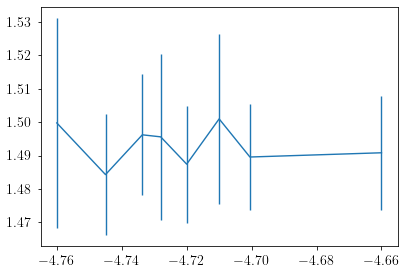

In [ ]:
plt.errorbar(masses,binder, binderErr)

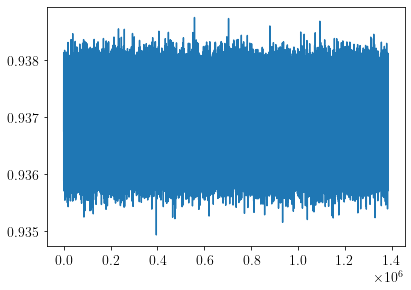

In [ ]:
plt.plot(data[m][v].av["M2"])

In [4]:
key = "phiRestored"
for m in masses:
    for v in volumes:
        data[m][v].load("OtOttp",key, direc=processedDataDir)
        data[m][v].load("OtOttp_blocks",key, direc=processedDataDir)
        data[m][v].load("OtOttpRatio",key, direc=processedDataDir)
        data[m][v].load("OtOttpRatio_blocks",key, direc=processedDataDir)

## Brute force fits

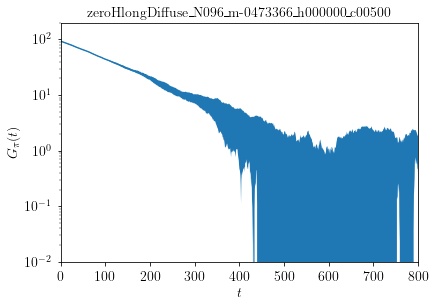

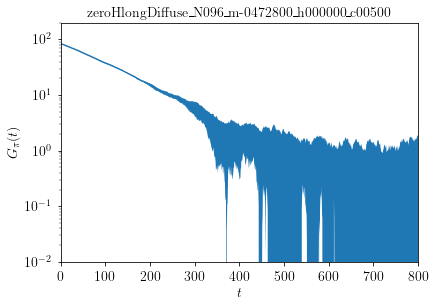

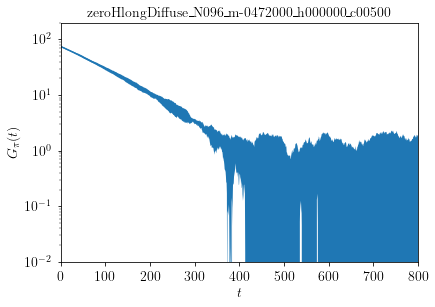

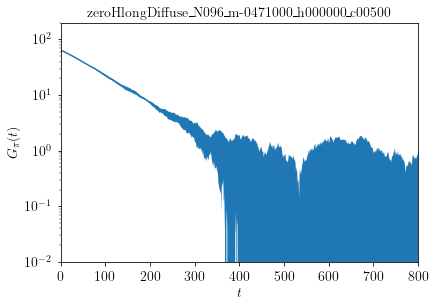

In [5]:
for m in masses:
    for v in volumes:
        plotter.plot(data[m][v],"OtOttp", key)
        plt.yscale('log')
        plt.title(dataFn[m][v], fontsize=14)
        xlabel(plt.gca(), "$t$")
        ylabel(plt.gca(), "$G_\pi(t)$")
        plt.xlim([0,800])
        plt.ylim([0.01,200])
        plt.show()

In [52]:
finiteLtaus = dict()
for m in masses:
    for v in volumes:
        fitter[m][v].setParValues("OtOttp", key, [60.0, 130.0])

fitter[masses[0]][v].fit("OtOttp", key, minInd=100,maxInd=250, prune=30)
fitter[masses[1]][v].fit("OtOttp", key, minInd=100,maxInd=250, prune=30)
fitter[masses[2]][v].fit("OtOttp", key, minInd=50,maxInd=250, prune=30)
fitter[masses[3]][v].fit("OtOttp", key, minInd=50,maxInd=250, prune=30)
#fitter[masses[4]][v].fit("OtOttp", key, minInd=50,maxInd=250, prune=30)
#fitter[masses[5]][v].fit("OtOttp", key, minInd=50,maxInd=250, prune=30)
#fitter[masses[6]][v].fit("OtOttp", key, minInd=50,maxInd=250, prune=30)
#fitter[masses[7]][v].fit("OtOttp", key, minInd=75,maxInd=250, prune=30)

for m in masses:
    taus = []
    tausErr = []
    for v in volumes:
        taus.append(fitter[m][v].par["OtOttp"][key][1])
        tausErr.append(fitter[m][v].parErr["OtOttp"][key][1])
    finiteLtaus[m] = StatResult((taus, tausErr))

In [53]:
[finiteLtaus[m].mean[0] for m in masses]

[128.50517025888678, 118.17129206757366, 104.36872889036523, 91.20091347223618]

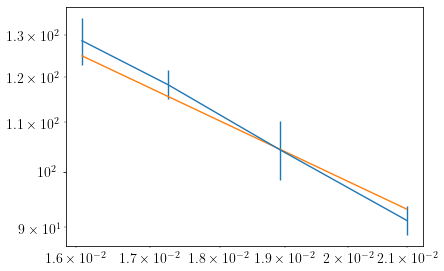

In [56]:
plt.errorbar(reducedMasses[:],[finiteLtaus[m].mean[0] for m in masses], [finiteLtaus[m].err[0] for m in masses])
plt.plot(reducedMasses[:],1.35*(reducedMasses[:]**(-1.096)))
plt.yscale('log')
plt.xscale('log')
plt.show()

In [134]:
1.096 / 1.50

0.7306666666666667

In [135]:
0.7344*1.7

1.24848

In [136]:
np.polyfit(np.log10(reducedMasses[1:-1]),np.log10(np.asarray([finiteLtaus[m].mean[0] for m in masses]))[1:-1], 1)

array([-1.25307586, -0.15108562])

## Sliding fits

In [14]:
def getTauSlide(minInds, data, k, vol):
    tauSlides = []
    tauSlidesErr = []


    for minI in minInds:
        fitter = Fitter(data, chi0 = chi0, chiperp = 1, L=vol, k=0)
        fitter.setParValues("OtOttp", k, [60.0, 120.0])
        fitter.fit("OtOttp", k, minInd=minI,maxInd=maxInd, prune=1)
        tauSlides.append(fitter.par["OtOttp"][k][1])
        tauSlidesErr.append(fitter.parErr["OtOttp"][k][1])

    return tauSlides, tauSlidesErr

def constantFit(const, constErr, plateau, endPlateau, guess=200.0):

    modelC = lambda par : par[0]


    res = const[plateau:endPlateau]
    resErr = constErr[plateau:endPlateau]
    chi2C2 = lambda par : np.sum(np.square((res - modelC(par)) / resErr ))
    fitC2 = Minuit(chi2C2, [guess], name=["b"])

    fitC2.errordef = Minuit.LEAST_SQUARES

    #fit.limits = []

    fitC2.migrad()
    fitC2.minos();


    return fitC2.values['b'],fitC2.errors['b']

def getTauSlide(minInds, data, k, vol):
    tauSlides = []
    tauSlidesErr = []


    for minI in minInds:
        fitter = Fitter(data, chi0 = chi0, chiperp = 1, L=vol, k=0)
        fitter.setParValues("OtOttp", k, [60.0, 120.0])
        fitter.fit("OtOttp", k, minInd=minI,maxInd=maxInd, prune=25)
        tauSlides.append(fitter.par["OtOttp"][k][1])
        tauSlidesErr.append(fitter.parErr["OtOttp"][k][1])

    return tauSlides, tauSlidesErr



def getTau(minInds, data, k, m, v, plateau, endPlateau, maxInd, guess=200.0, plot = True):
    tauSlides, tauSlidesErr = getTauSlide(minInds, data, key, v)

    plt.figure(0)
    #plt.yscale('log')
    plt.errorbar(minInds, tauSlides, tauSlidesErr)
    #plt.title(dataFn[m][v], fontsize=14)
    xlabel(plt.gca(), "$t$")
    ylabel(plt.gca(), "$G_\pi(t)$")
    #plt.xlim([0,endPlateau])

    fit, fitErr = constantFit(tauSlides, tauSlidesErr, plateau, endPlateau)

    xs = [minInds[plateau], minInds[endPlateau]]
    ys = np.asarray([fit, fit])
    errs = np.asarray([fitErr, fitErr])

    plt.ylim([0.98*fit, 1.08*fit])


    plt.fill_between(xs, ys - errs,ys + errs, linewidth=0, zorder=1, color='r')

    return StatResult([tauSlides[plateau], tauSlidesErr[plateau]])

In [46]:
taus = []

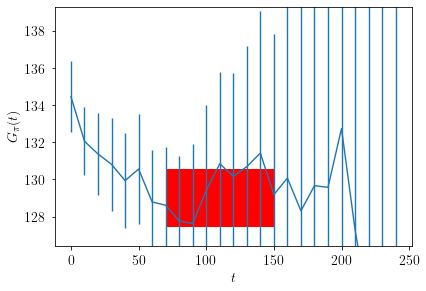

In [47]:
minInds = list(range(0,250,10))
maxInd = 300

plateau = 7
endPlateau = 15

m = masses[0]
v = volumes[0]

taus.append(getTau(minInds, data[m][v], key, m, v, plateau, endPlateau, maxInd))

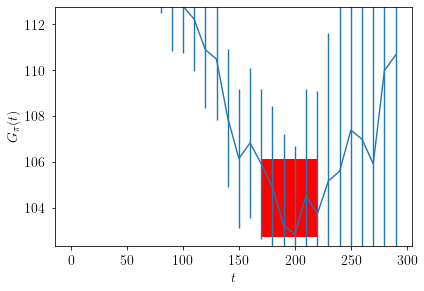

In [48]:
minInds = list(range(0,300,10))
maxInd = 450
m = masses[1]
v = volumes[0]

plateau = 17
endPlateau = 22


taus.append(getTau(minInds, data[m][v], key, m, v, plateau, endPlateau, maxInd))


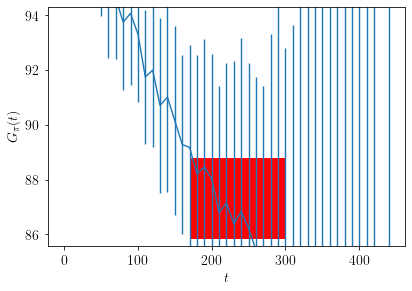

In [49]:
minInds = list(range(0,450,10))
maxInd = 500
m = masses[2]
v = volumes[0]

plateau = 17
endPlateau = 30


taus.append(getTau(minInds, data[m][v], key, m, v, plateau, endPlateau, maxInd))


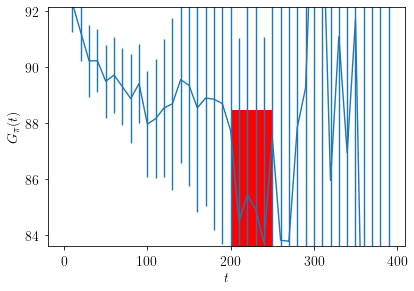

In [50]:
minInds = list(range(0,400,10))
maxInd = 450
m = masses[3]
v = volumes[0]

plateau = 20
endPlateau = 25


taus.append(getTau(minInds, data[m][v], key, m, v, plateau, endPlateau, maxInd))


In [41]:
minInds = list(range(0,120,10))
maxInd = 250
m = masses[4]
v = volumes[0]

plateau = 5
endPlateau = 10


taus.append(getTau(minInds, data[m][v], key, m, v, plateau, endPlateau, maxInd))


IndexError: list index out of range

In [42]:
minInds = list(range(0,90,10))
maxInd = 250
m = masses[5]
v = volumes[0]

plateau = 3
endPlateau = 7


taus.append(getTau(minInds, data[m][v], key, m, v, plateau, endPlateau, maxInd))


IndexError: list index out of range

In [43]:
minInds = list(range(0,100,10))
maxInd = 250
m = masses[6]
v = volumes[0]

plateau = 1
endPlateau = 4


taus.append(getTau(minInds, data[m][v], key, m, v, plateau, endPlateau, maxInd))


IndexError: list index out of range

In [44]:
minInds = list(range(0,180,10))
maxInd = 250
m = masses[7]
v = volumes[0]

plateau = 9
endPlateau = 15


taus.append(getTau(minInds, data[m][v], key, m, v, plateau, endPlateau, maxInd))


IndexError: list index out of range

In [45]:
1.28*reducedMasses[:]**(0.2)

array([0.56032982, 0.56830113, 0.57885685, 0.59105402])

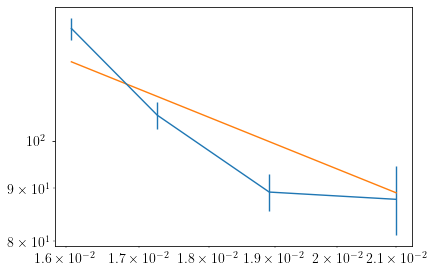

In [51]:
plt.errorbar(reducedMasses, [t.mean for t in taus], [t.err for t in taus])
plt.yscale('log')
plt.xscale('log')
plt.plot(reducedMasses[:],1.28*reducedMasses[:]**(-1.098) )

## Effective masses

In [275]:
taus

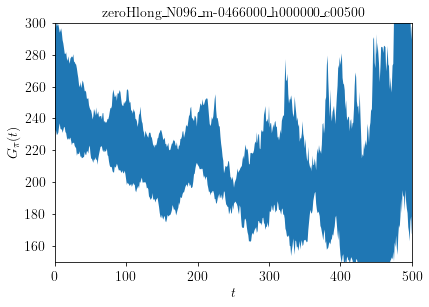

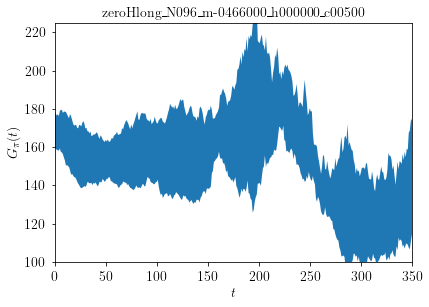

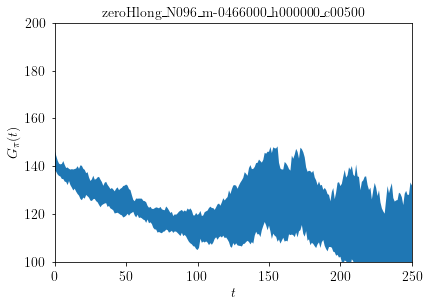

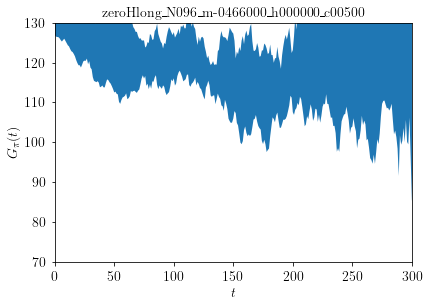

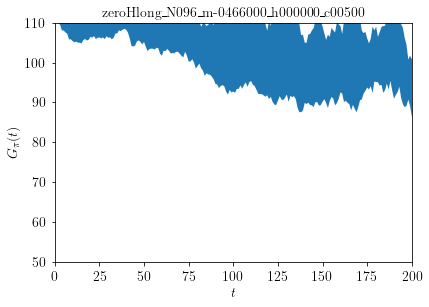

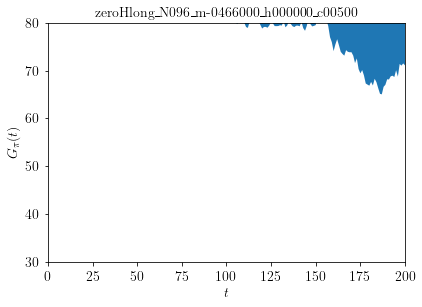

In [36]:
plt.figure(0)
plotter.plot(data[masses[0]][v],"OtOttpRatio", key)
#plt.yscale('log')
plt.title(dataFn[m][v], fontsize=14)
xlabel(plt.gca(), "$t$")
ylabel(plt.gca(), "$G_\pi(t)$")
plt.xlim([0,500])
plt.ylim([150,300])

plt.figure(1)
plotter.plot(data[masses[1]][v],"OtOttpRatio", key)
#plt.yscale('log')
plt.title(dataFn[m][v], fontsize=14)
xlabel(plt.gca(), "$t$")
ylabel(plt.gca(), "$G_\pi(t)$")
plt.xlim([0,350])
plt.ylim([100,225])

plt.figure(2)
plotter.plot(data[masses[2]][v],"OtOttpRatio", key)
#plt.yscale('log')
plt.title(dataFn[m][v], fontsize=14)
xlabel(plt.gca(), "$t$")
ylabel(plt.gca(), "$G_\pi(t)$")
plt.xlim([0,250])
plt.ylim([100,200])

plt.figure(3)
plotter.plot(data[masses[3]][v],"OtOttpRatio", key)
#plt.yscale('log')
plt.title(dataFn[m][v], fontsize=14)
xlabel(plt.gca(), "$t$")
ylabel(plt.gca(), "$G_\pi(t)$")
plt.xlim([0,300])
plt.ylim([70,130])


plt.figure(4)
plotter.plot(data[masses[4]][v],"OtOttpRatio", key)
#plt.yscale('log')
plt.title(dataFn[m][v], fontsize=14)
xlabel(plt.gca(), "$t$")
ylabel(plt.gca(), "$G_\pi(t)$")
plt.xlim([0,200])
plt.ylim([50,110])


plt.figure(5)
plotter.plot(data[masses[5]][v],"OtOttpRatio", key)
#plt.yscale('log')
plt.title(dataFn[m][v], fontsize=14)
xlabel(plt.gca(), "$t$")
ylabel(plt.gca(), "$G_\pi(t)$")
plt.xlim([0,200])
plt.ylim([30,80])

plt.show()

In [66]:
effMasses = np.zeros(len(masses))
effMassesErr = np.zeros(len(masses))

/home/adrienflorio/.local/lib/python3.8/site-packages/iminuit/minuit.py:683: ComplexWarning: Casting complex values to real discards the imaginary part
  fm = migrad(ncall, self._tolerance)
/home/adrienflorio/.local/lib/python3.8/site-packages/iminuit/minuit.py:1370: ComplexWarning: Casting complex values to real discards the imaginary part
  me = minos(self._var2pos[par], ncall, self._tolerance)


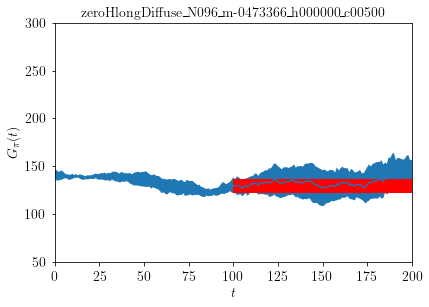

In [67]:
plateau = 100
endPlateau = 200
modelC = lambda par : par[0]

m = masses[0]


res = data[m][v].OtOttpRatio[key].mean[plateau:endPlateau:50]
resErr = data[m][v].OtOttpRatio[key].err[plateau:endPlateau:50]
chi2C2 = lambda par : np.sum(np.square((res - modelC(par)) / resErr ))
fitC2 = Minuit(chi2C2, [200.0], name=["b"])

fitC2.errordef = Minuit.LEAST_SQUARES

#fit.limits = []

fitC2.migrad()
fitC2.minos();


plt.figure(0)
plotter.plot(data[m][v],"OtOttpRatio", key)
#plt.yscale('log')
plt.title(dataFn[m][v], fontsize=14)
xlabel(plt.gca(), "$t$")
ylabel(plt.gca(), "$G_\pi(t)$")
plt.xlim([0,endPlateau])
plt.ylim([50,300])


xs = [plateau,endPlateau]
ys = np.asarray([fitC2.values['b'],fitC2.values['b']])
errs = np.asarray([fitC2.errors['b'],fitC2.errors['b']])

plt.fill_between(xs, ys - errs,ys + errs, linewidth=0, zorder=1, color='r')

effMasses[0] = fitC2.values['b']
effMassesErr[0] = fitC2.errors['b']


/home/adrienflorio/.local/lib/python3.8/site-packages/iminuit/minuit.py:683: ComplexWarning: Casting complex values to real discards the imaginary part
  fm = migrad(ncall, self._tolerance)
/home/adrienflorio/.local/lib/python3.8/site-packages/iminuit/minuit.py:1370: ComplexWarning: Casting complex values to real discards the imaginary part
  me = minos(self._var2pos[par], ncall, self._tolerance)


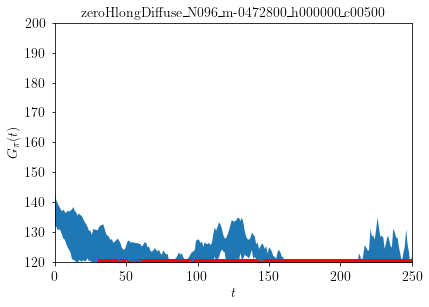

In [68]:
plateau = 30
endPlateau = 250

modelC = lambda par : par[0]

m = masses[1]


res = data[m][v].OtOttpRatio[key].mean[plateau:endPlateau:50]
resErr = data[m][v].OtOttpRatio[key].err[plateau:endPlateau:50]
chi2C2 = lambda par : np.sum(np.square((res - modelC(par)) / resErr ))
fitC2 = Minuit(chi2C2, [200.0], name=["b"])

fitC2.errordef = Minuit.LEAST_SQUARES

#fit.limits = []

fitC2.migrad()
fitC2.minos();


plt.figure(0)
plotter.plot(data[m][v],"OtOttpRatio", key)
#plt.yscale('log')
plt.title(dataFn[m][v], fontsize=14)
xlabel(plt.gca(), "$t$")
ylabel(plt.gca(), "$G_\pi(t)$")
plt.xlim([0,endPlateau])
plt.ylim([120,200])


xs = [plateau,endPlateau]
ys = np.asarray([fitC2.values['b'],fitC2.values['b']])
errs = np.asarray([fitC2.errors['b'],fitC2.errors['b']])

plt.fill_between(xs, ys - errs,ys + errs, linewidth=0, zorder=1, color='r')

effMasses[1] = fitC2.values['b']
effMassesErr[1] = fitC2.errors['b']


/home/adrienflorio/.local/lib/python3.8/site-packages/iminuit/minuit.py:683: ComplexWarning: Casting complex values to real discards the imaginary part
  fm = migrad(ncall, self._tolerance)
/home/adrienflorio/.local/lib/python3.8/site-packages/iminuit/minuit.py:1370: ComplexWarning: Casting complex values to real discards the imaginary part
  me = minos(self._var2pos[par], ncall, self._tolerance)


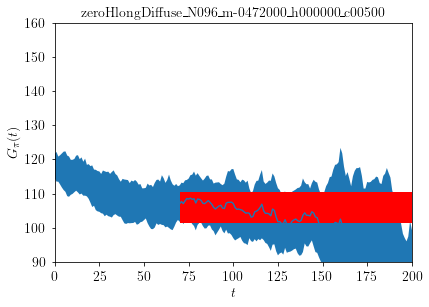

In [69]:
plateau = 70
endPlateau = 200

modelC = lambda par : par[0]

m = masses[2]


res = data[m][v].OtOttpRatio[key].mean[plateau:endPlateau:50]
resErr = data[m][v].OtOttpRatio[key].err[plateau:endPlateau:50]
chi2C2 = lambda par : np.sum(np.square((res - modelC(par)) / resErr ))
fitC2 = Minuit(chi2C2, [200.0], name=["b"])

fitC2.errordef = Minuit.LEAST_SQUARES

#fit.limits = []

fitC2.migrad()
fitC2.minos();


plt.figure(0)
plotter.plot(data[m][v],"OtOttpRatio", key)
#plt.yscale('log')
plt.title(dataFn[m][v], fontsize=14)
xlabel(plt.gca(), "$t$")
ylabel(plt.gca(), "$G_\pi(t)$")
plt.xlim([0,endPlateau])
plt.ylim([90,160])


xs = [plateau,endPlateau]
ys = np.asarray([fitC2.values['b'],fitC2.values['b']])
errs = np.asarray([fitC2.errors['b'],fitC2.errors['b']])

plt.fill_between(xs, ys - errs,ys + errs, linewidth=0, zorder=1, color='r')

effMasses[2] = fitC2.values['b']
effMassesErr[2] = fitC2.errors['b']


/home/adrienflorio/.local/lib/python3.8/site-packages/iminuit/minuit.py:683: ComplexWarning: Casting complex values to real discards the imaginary part
  fm = migrad(ncall, self._tolerance)
/home/adrienflorio/.local/lib/python3.8/site-packages/iminuit/minuit.py:1370: ComplexWarning: Casting complex values to real discards the imaginary part
  me = minos(self._var2pos[par], ncall, self._tolerance)


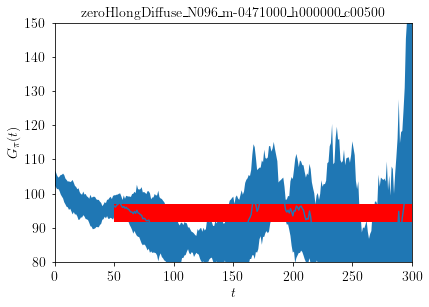

In [70]:
plateau = 50
endPlateau = 300

modelC = lambda par : par[0]

m = masses[3]


res = data[m][v].OtOttpRatio[key].mean[plateau:endPlateau:50]
resErr = data[m][v].OtOttpRatio[key].err[plateau:endPlateau:50]
chi2C2 = lambda par : np.sum(np.square((res - modelC(par)) / resErr ))
fitC2 = Minuit(chi2C2, [200.0], name=["b"])

fitC2.errordef = Minuit.LEAST_SQUARES

#fit.limits = []

fitC2.migrad()
fitC2.minos();


plt.figure(0)
plotter.plot(data[m][v],"OtOttpRatio", key)
#plt.yscale('log')
plt.title(dataFn[m][v], fontsize=14)
xlabel(plt.gca(), "$t$")
ylabel(plt.gca(), "$G_\pi(t)$")
plt.xlim([0,endPlateau])
plt.ylim([80,150])


xs = [plateau,endPlateau]
ys = np.asarray([fitC2.values['b'],fitC2.values['b']])
errs = np.asarray([fitC2.errors['b'],fitC2.errors['b']])

plt.fill_between(xs, ys - errs,ys + errs, linewidth=0, zorder=1, color='r')

effMasses[3] = fitC2.values['b']
effMassesErr[3] = fitC2.errors['b']


/home/adrienflorio/.local/lib/python3.8/site-packages/iminuit/minuit.py:683: ComplexWarning: Casting complex values to real discards the imaginary part
  fm = migrad(ncall, self._tolerance)
/home/adrienflorio/.local/lib/python3.8/site-packages/iminuit/minuit.py:1370: ComplexWarning: Casting complex values to real discards the imaginary part
  me = minos(self._var2pos[par], ncall, self._tolerance)


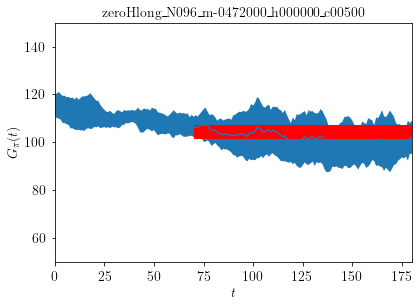

In [42]:
plateau = 70
endPlateau = 180

modelC = lambda par : par[0]

m = masses[4]


res = data[m][v].OtOttpRatio[key].mean[plateau:endPlateau:20]
resErr = data[m][v].OtOttpRatio[key].err[plateau:endPlateau:20]
chi2C2 = lambda par : np.sum(np.square((res - modelC(par)) / resErr ))
fitC2 = Minuit(chi2C2, [200.0], name=["b"])

fitC2.errordef = Minuit.LEAST_SQUARES

#fit.limits = []

fitC2.migrad()
fitC2.minos();


plt.figure(0)
plotter.plot(data[m][v],"OtOttpRatio", key)
#plt.yscale('log')
plt.title(dataFn[m][v], fontsize=14)
xlabel(plt.gca(), "$t$")
ylabel(plt.gca(), "$G_\pi(t)$")
plt.xlim([0,endPlateau])
plt.ylim([50,150])


xs = [plateau,endPlateau]
ys = np.asarray([fitC2.values['b'],fitC2.values['b']])
errs = np.asarray([fitC2.errors['b'],fitC2.errors['b']])

plt.fill_between(xs, ys - errs,ys + errs, linewidth=0, zorder=1, color='r')

effMasses[4] = fitC2.values['b']
effMassesErr[4] = fitC2.errors['b']


/home/adrienflorio/.local/lib/python3.8/site-packages/iminuit/minuit.py:683: ComplexWarning: Casting complex values to real discards the imaginary part
  fm = migrad(ncall, self._tolerance)
/home/adrienflorio/.local/lib/python3.8/site-packages/iminuit/minuit.py:1370: ComplexWarning: Casting complex values to real discards the imaginary part
  me = minos(self._var2pos[par], ncall, self._tolerance)


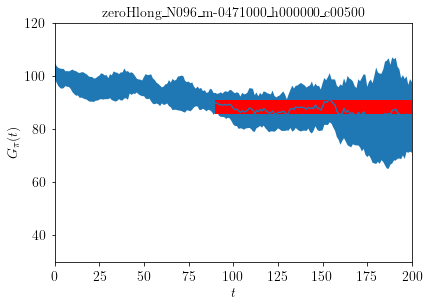

In [43]:
plateau = 90
endPlateau = 200

modelC = lambda par : par[0]

m = masses[5]


res = data[m][v].OtOttpRatio[key].mean[plateau:endPlateau:20]
resErr = data[m][v].OtOttpRatio[key].err[plateau:endPlateau:20]
chi2C2 = lambda par : np.sum(np.square((res - modelC(par)) / resErr ))
fitC2 = Minuit(chi2C2, [200.0], name=["b"])

fitC2.errordef = Minuit.LEAST_SQUARES

#fit.limits = []

fitC2.migrad()
fitC2.minos();


plt.figure(0)
plotter.plot(data[m][v],"OtOttpRatio", key)
#plt.yscale('log')
plt.title(dataFn[m][v], fontsize=14)
xlabel(plt.gca(), "$t$")
ylabel(plt.gca(), "$G_\pi(t)$")
plt.xlim([0,endPlateau])
plt.ylim([30,120])


xs = [plateau,endPlateau]
ys = np.asarray([fitC2.values['b'],fitC2.values['b']])
errs = np.asarray([fitC2.errors['b'],fitC2.errors['b']])

plt.fill_between(xs, ys - errs,ys + errs, linewidth=0, zorder=1, color='r')

effMasses[5] = fitC2.values['b']
effMassesErr[5] = fitC2.errors['b']


/home/adrienflorio/.local/lib/python3.8/site-packages/iminuit/minuit.py:683: ComplexWarning: Casting complex values to real discards the imaginary part
  fm = migrad(ncall, self._tolerance)
/home/adrienflorio/.local/lib/python3.8/site-packages/iminuit/minuit.py:1370: ComplexWarning: Casting complex values to real discards the imaginary part
  me = minos(self._var2pos[par], ncall, self._tolerance)


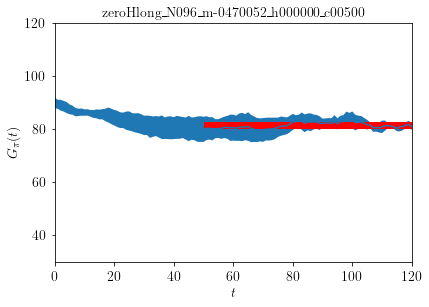

In [50]:
plateau = 50
endPlateau = 120

modelC = lambda par : par[0]

m = masses[6]


res = data[m][v].OtOttpRatio[key].mean[plateau:endPlateau:20]
resErr = data[m][v].OtOttpRatio[key].err[plateau:endPlateau:20]
chi2C2 = lambda par : np.sum(np.square((res - modelC(par)) / resErr ))
fitC2 = Minuit(chi2C2, [200.0], name=["b"])

fitC2.errordef = Minuit.LEAST_SQUARES

#fit.limits = []

fitC2.migrad()
fitC2.minos();


plt.figure(0)
plotter.plot(data[m][v],"OtOttpRatio", key)
#plt.yscale('log')
plt.title(dataFn[m][v], fontsize=14)
xlabel(plt.gca(), "$t$")
ylabel(plt.gca(), "$G_\pi(t)$")
plt.xlim([0,endPlateau])
plt.ylim([30,120])


xs = [plateau,endPlateau]
ys = np.asarray([fitC2.values['b'],fitC2.values['b']])
errs = np.asarray([fitC2.errors['b'],fitC2.errors['b']])

plt.fill_between(xs, ys - errs,ys + errs, linewidth=0, zorder=1, color='r')

effMasses[6] = fitC2.values['b']
effMassesErr[6] = fitC2.errors['b']


/home/adrienflorio/.local/lib/python3.8/site-packages/iminuit/minuit.py:683: ComplexWarning: Casting complex values to real discards the imaginary part
  fm = migrad(ncall, self._tolerance)
/home/adrienflorio/.local/lib/python3.8/site-packages/iminuit/minuit.py:1370: ComplexWarning: Casting complex values to real discards the imaginary part
  me = minos(self._var2pos[par], ncall, self._tolerance)


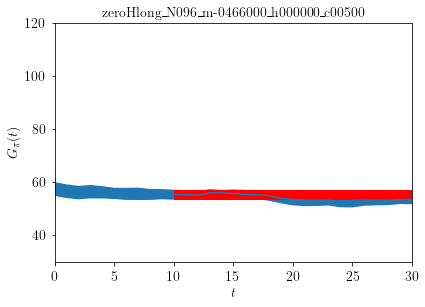

In [45]:
plateau = 10
endPlateau = 30

modelC = lambda par : par[0]

m = masses[7]


res = data[m][v].OtOttpRatio[key].mean[plateau:endPlateau:20]
resErr = data[m][v].OtOttpRatio[key].err[plateau:endPlateau:20]
chi2C2 = lambda par : np.sum(np.square((res - modelC(par)) / resErr ))
fitC2 = Minuit(chi2C2, [200.0], name=["b"])

fitC2.errordef = Minuit.LEAST_SQUARES

#fit.limits = []

fitC2.migrad()
fitC2.minos();


plt.figure(0)
plotter.plot(data[m][v],"OtOttpRatio", key)
#plt.yscale('log')
plt.title(dataFn[m][v], fontsize=14)
xlabel(plt.gca(), "$t$")
ylabel(plt.gca(), "$G_\pi(t)$")
plt.xlim([0,endPlateau])
plt.ylim([30,120])


xs = [plateau,endPlateau]
ys = np.asarray([fitC2.values['b'],fitC2.values['b']])
errs = np.asarray([fitC2.errors['b'],fitC2.errors['b']])

plt.fill_between(xs, ys - errs,ys + errs, linewidth=0, zorder=1, color='r')

effMasses[7] = fitC2.values['b']
effMassesErr[7] = fitC2.errors['b']


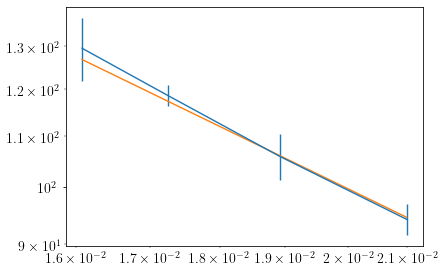

In [74]:
plt.errorbar(reducedMasses[:], effMasses[:], effMassesErr[:])
plt.yscale('log')
plt.xscale('log')
plt.plot(reducedMasses[:],1.36*reducedMasses[:]**(-1.098))


In [11]:
0.40 * 1.47* 1.83

1.0760399999999999

In [194]:
 1.83 * 0.40

0.7320000000000001